 # Programming Assignment - FakeFinder : Building an AI to Detect AI-Generated Images



Can Machines Detect Their Own Creations?

Welcome, **AI Explorer**! In this assignment, you'll embark on a journey into the dynamic landscape of AutoML—where you'll discover how artificial intelligence can learn to optimize itself.
Your expedition’s goal? Equip your AI Explorer with the skills to distinguish genuine images from creations generated by state-of-the-art AI models like Stable Diffusion, MidJourney, and DALL·E.


In this comprehensive exploration of image authenticity detection, you'll master the following techniques:

* Construct **Flexible Convolutional Neural Networks (CNNs)** by using `nn.Sequential` to dynamically create adaptable architectures, based on varying hyperparameters such as the number of layers and filter sizes.
* Design a robust **hyperparameter search space** for Optuna to optimize models.
* Define and implement an **objective function** that guides the automated hyperparameter tuning process.
* Run an Optuna study to discover effective CNN configurations.
* Analyze **efficiency metrics** to refine your selection among the top-performing CNN models within the study.


You will now chart a course to build a robust and swift FakeFinder!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents

- [Imports](#0)
- [1 - Preparing the Expedition: Data Inspection](#1)
    - [1.1 - Exploring real vs. fake images](#1-1)
- [2 - Crafting Your AI Explorer: Building a Flexible CNN](#2)
    - **[Exercise 1 - FlexibleCNN](#ex-1)**
- [3 - Charting New Territories: Designing the Hyperparameter Search Space](#3)
    - **[Exercise 2 - design_search_space](#ex-2)**
- [4 - Letting AI Take the Lead: Implementing the Optuna Objective](#4)
    - **[Exercise 3 - objective_function](#ex-3)**
- [5 - Navigating the Hyperparameter Landscape: Running the Optuna Study](#5)
    - [5.1 - Analyzing the Results: Evaluating the Best Models](#5-1)
        - **[Exercise 4 - get_trainable_params](#ex-4)**
- [6 - (Optional) Evaluating the model with alternative metrics](#6)
    - [6.1 - Precision and Recall](#6-1)

<a name='0'></a>
## Imports

In [1]:
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchmetrics.classification import Accuracy, Precision, Recall

from helper_utils import evaluate_model, extract_attr, get_data_loaders, training_epoch

In [2]:
import helper_utils
import unittests

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cuda


<a name='1'></a>
## 1 - Preparing the Expedition: Data Inspection

 You'll be working with a curated collection of images showcasing both real images and synthetic creations from state-of-the-art generative models.
 The dataset you'll explore is a subset of the [AI-Generated Images vs Real Images](https://www.kaggle.com/datasets/tristanzhang32/ai-generated-images-vs-real-images) dataset.

 The original dataset contains 60,000 images—half generated by advanced AI models (Stable Diffusion, MidJourney, and DALL·E), and half genuine images from sources like Pexels, Unsplash, and WikiArt. 
 To keep your exploration efficient and manageable, you'll work with a carefully selected subset:
 - **5,000 images** for training.
 - **1,000 images** for testing.


 The images are organized into two main folders (`train` and `test`), each containing two subdirectories:
 - `real`: genuine images.
 - `fake`: AI-generated synthetic images.


Note: Some of the images labeled as `real` are actually drawings rather than photographs.

<a name='1-1'></a>
### 1.1 - Exploring real vs. fake images

It's time to visually explore the terrain you'll be traversing. 
You’ll visualize some random images -from both the training and testing sets- to get familiar with both categories.

 Here you will iterate through the dataset, displaying a handful of representative images for an initial exploration.
 The `helper_utils` module provides a function to display random images from the dataset.

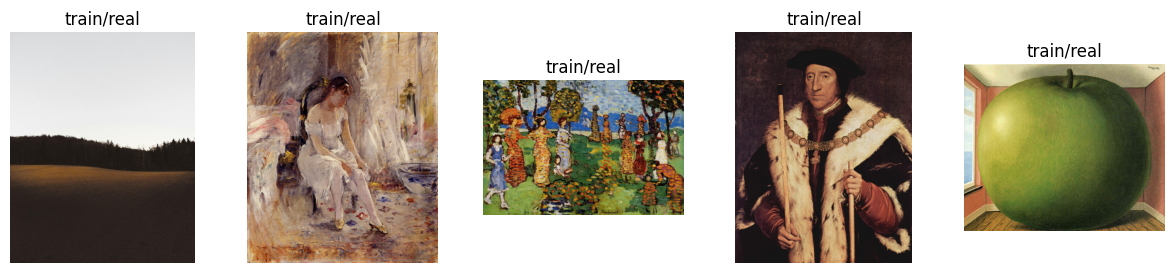

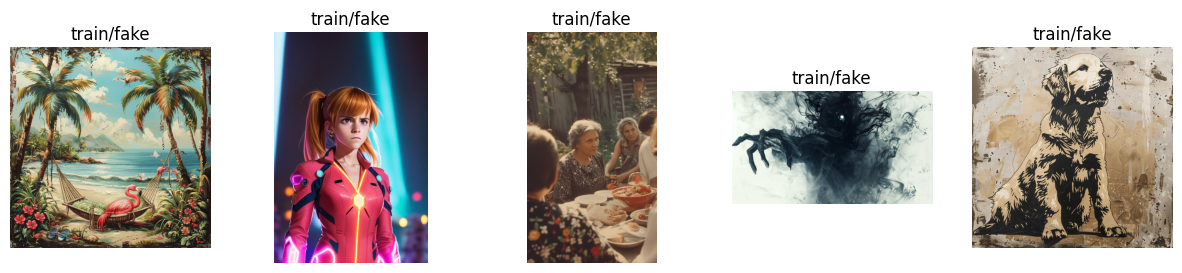

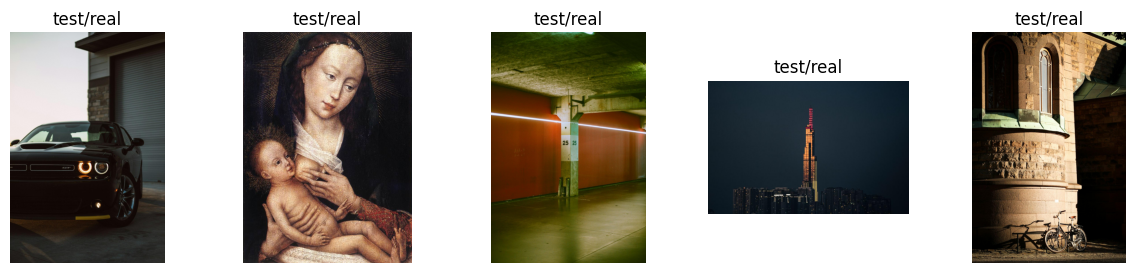

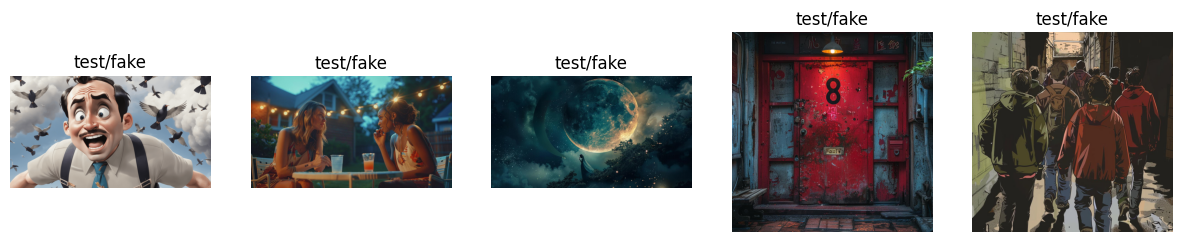

In [4]:
AIvsReal_path = "./AIvsReal_sampled"  

# Display example images
for split in ['train', 'test']:
    for category in ['real', 'fake']:
        helper_utils.show_random_images(split, category, AIvsReal_path, num_images=5)

<a name='2'></a>
## 2 - Crafting Your AI Explorer: Building a Flexible CNN
In this section, you'll construct the core of your AI Explorer: a **flexible convolutional neural network (CNN)**. 
Instead of building a fixed CNN architecture, you'll define a model that is dynamically constructed based on provided parameters, such as the number of layers, filter sizes, and activation functions. 

This parameterization allows for tailoring the network to specific tasks and datasets, enhancing its effectiveness without the need to redesign it from scratch.
Additionally, the scalability of this approach ensures the network can efficiently adapt to varying complexities,
from simple to advanced tasks, making it versatile in its applications.

This flexibility will be crucial later when you automate architecture exploration using Optuna.

<a name='ex-1'></a>
### Exercise 1 - FlexibleCNN

**Your Task:**

For the `features` neural network setup (achieved with [`ModuleList`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ModuleList.html)):

* **`__init__`**: 
    * Construct each `convolutional_block` using a `Sequential` container composed of:
        * A 2d convolutional layer
        * A 2d [batch normalization layer](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) to normalize the output of the convolutional layer.
        * A ReLU activation function
        * A 2d max pooling layer
    * Ensure each convolutional block connects correctly by properly setting `in_channels` for subsequent layers.
>
 * **`_create_classifier`**: 
    * Use `nn.Sequential` to build the classifier structure with the following components:
        - dropout layer (provided), 
        - fully connected layer, 
        - ReLU activation function (provided),
        - dropout layer (provided),
        - linear output layer.
>
 * **`forward`**: 
    * Flatten the output after the last layer in the `.features` module to prepare it for the fully connected layer of the classifier, while keeping the batch dimension intact.
    * Extract the size of the flattened tensor `x` to determine the input size for the fully connected layer.
    * Create the classifier, based on the `._flattened_size` attribute.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you find yourself stuck, here is a more detailed breakdown.

**For the `__init__` method:**
* The `convolutional_block` is an `nn.Sequential` container that you will define inside the for loop.
* The layers inside it should be initialized as follows:
    * `nn.Conv2d`: Use the current `in_channels`, the `out_channels` for this layer, the specified `kernel_size`, and the calculated `padding`.
    * `nn.BatchNorm2d`: The `num_features` argument for this layer must match the `out_channels` of the preceding convolutional layer.
    * `nn.MaxPool2d`: Set the `kernel_size` to `2` and the `stride` to `2`.
* To update the channels for the next iteration, use this logic:
    * > `in_channels = the out_channels from the current layer`

**For the `_create_classifier` method:**
* This is another `nn.Sequential` container.
* The first `nn.Linear` layer should map from `flattened_size` to `self.fc_size`.
* The final `nn.Linear` layer should map from `self.fc_size` to `self.num_classes`.

**For the `forward` method:**
* To flatten the tensor `x`, you can use pseudocode like this:
    * > `x = flatten the tensor x, starting from dimension 1`
* To get the size for the classifier, the pseudocode is:
    * > `self._flattened_size = get the size of dimension 1 from the tensor x`
* To create the classifier, simply call the helper method you already implemented:
    * > `call the _create_classifier method, passing it self._flattened_size`

</details>

In [9]:
# GRADED CLASS: FlexibleCNN

class FlexibleCNN(nn.Module):
    """
    A customizable convolutional neural network (CNN) for image classification.
    It dynamically constructs convolutional blocks based on provided hyperparameters
    such as the number of layers, filter sizes, kernel sizes, and dropout rates.
    """

    def __init__(
        self, n_layers, n_filters, kernel_sizes, dropout_rate, fc_size, num_classes=2
    ):
        """
        Initializes the FlexibleCNN.

        Args:
            n_layers (int): Number of convolutional layers.
            n_filters (list): Number of filters for each convolutional layer.
            kernel_sizes (list): Kernel sizes for each convolutional layer.
            dropout_rate (float): Dropout rate for regularization.
            fc_size (int): Number of units in the fully connected layer.
            num_classes (int): Number of output classes.
        """
        super(FlexibleCNN, self).__init__()

        self.num_classes = num_classes
        
        self.features = nn.ModuleList()
        in_channels = 3  # RGB input images

        ### START CODE HERE ###
        
        for i in range(n_layers): 
            # Create convolutional layer with dynamic parameters
            
            # Extract the number of filters and kernel size for the current layer, from n_filters and kernel_sizes
            out_channels = n_filters[i] 
            kernel_size = kernel_sizes[i] 
            
            
            padding = (kernel_size - 1) // 2 

            # Create a convolutional block, by using a `nn.Sequential` container to group layers together
            block=nn.Sequential(
                # Add a Convolutional layer `Conv2d` with parameters: `in_channels`, `out_channels`, `kernel_size`, and `padding`
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,padding=padding),
                # Add a Batch normalization layer `BatchNorm2d` with `num_features` as `out_channels` 
                nn.BatchNorm2d(out_channels),
                # Add a ReLU activation
                nn.ReLU(), 
                # Add a MaxPool2d layer `MaxPool2d`, with `kernel_size=2` and `stride=2`
                nn.MaxPool2d(kernel_size=2,stride=2)
            )
                
            # Append the convolutional block to the features ModuleList
            self.features.append(block)

            # Update in_channels for the next layer (the input channels for the next layer is the output channels of the current layer)
            in_channels = out_channels
            

        ### END CODE HERE ###

        self.dropout_rate = dropout_rate
        self.fc_size = fc_size        
                
        # Classifier will be initialized after calculating flattened size
        self.classifier = None  
        self._flattened_size = None 
        

    def _create_classifier(self, flattened_size):
        """
        Creates the fully connected classifier part of the model based on the flattened feature size.

        Args:
            flattened_size (int): Size of the flattened feature maps.
        """
        ### START CODE HERE ###

        # Create the classifier using a Sequential container
        self.classifier = nn.Sequential(
            # Add a dropout layer with the dropout rate defined at initialization
            nn.Dropout(p=self.dropout_rate), 
            # Add a fully connected layer `Linear` with `in_features=flattened_size` and `out_features` as `fc_size`
            nn.Linear(in_features=flattened_size,out_features=self.fc_size),
            # Activation function
            nn.ReLU(), 
            # # Another dropout layer
            nn.Dropout(p=self.dropout_rate), 
            # Add the final fully connected layer with `in_features` as `fc_size` and `out_features` as `num_classes`
            nn.Linear(in_features=self.fc_size,out_features=self.num_classes)
        ) 

        ### END CODE HERE ###

    def forward(self, x):
        """
        Defines the forward pass of the FlexibleCNN.

        Args:
            x (torch.Tensor): Input tensor (batch of images).

        Returns:
            torch.Tensor: Output tensor (classification scores).
        """
        # Apply convolutional feature extraction layers
        for layer in self.features:
            x = layer(x)

        ### START CODE HERE ###

        # Flatten the output x for the classifier (start_dim=1 to keep the batch dimension)
        x = torch.flatten(x,1)

        # Dynamically create classifier if it doesn't exist
        if self.classifier is None:
            # Get the size of the flattened feature maps from the x tensor
            self._flattened_size = x.size(1)

            # Create the classifier with the `_flattened_size` 
            self._create_classifier(self._flattened_size)

        ### END CODE HERE ###
            
            # Extract the device from the input tensor
            device = x.device
            
            # Move the classifier to the same device as the input tensor, to ensure compatibility with GPU/CPU
            if self.classifier is not None:
                self.classifier.to(device)

        # Classification
        return self.classifier(x)

In [10]:
# Create the model with specific parameters
n_layers = 3
n_filters = [16, 32, 64]
kernel_sizes = [3, 3, 3]
dropout_rate = 0.5
fc_size = 128

model = FlexibleCNN(
    n_layers=n_layers,
    n_filters=n_filters,
    kernel_sizes=kernel_sizes,
    dropout_rate=dropout_rate,
    fc_size=fc_size,
).to(DEVICE)

resolution = 32
x_sample = torch.randn(1, 3, resolution, resolution).to(DEVICE)  # Example input tensor


# Forward pass through the model
output = model(x_sample)

# print the model features architecture
print(f"FlexibleCNN features architecture:\n{model.features}")

print(f"FlexibleCNN classifier architecture:\n{model.classifier}")

FlexibleCNN features architecture:
ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
FlexibleCNN classifier architecture:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1)

 #### Expected Output:

 ```
FlexibleCNN features architecture:
ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
FlexibleCNN classifier architecture:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=1024, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=128, out_features=2, bias=True)
)
 ```

In [11]:
# Test your code!
unittests.exercise_1(FlexibleCNN)

 All tests passed!


<a name='3'></a>
## 3 - Charting New Territories: Designing the Hyperparameter Search Space

With your flexible CNN architecture ready, the next step of your expedition involves charting the hyperparameter landscape.
You'll create a detailed search space using **Optuna**, enabling automatic exploration of architectural and training hyperparameters.  
Carefully defining this search space allows your AI Explorer to efficiently navigate different configurations for identifying optimal models.

<a name='ex-2'></a>
### Exercise 2 - design_search_space

**Your Task:**

Implement a structured search space for Optuna that selects values for both architectural and training hyperparameters.

* Use the `trial.suggest_int`, `trial.suggest_float`, and `trial.suggest_categorical` methods to define these parameters (for a summary of the available distributions see [Optuna Trial](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html)).
* Make sure that the right types (`int`, `float`, `categorical`) are used for each hyperparameter, and ensure that the limits are the proposed ones within the code. 
* **When using `trial.suggest_` methods, always provide a name for the hyperparameter. The names used match exactly those defined in the code to maintain consistency.**

Your search space should clearly define ranges or options for:

* **`CNN Architecture`**: 
>    * Number of convolutional layers. (`n_layers`)
>    * Number of filters for each convolutional layer. (`n_filters_layer{i}`)
>    * Kernel sizes. (`kernel_size_layer{i}`)
>    * Dropout rates. (`dropout_rate`)
>    * Number of units in the fully connected (dense) layer. (`fc_size`)

* **`Training Parameters`**: 
>    * Learning rate. (`learning_rate`)
>    * Image resolution. (`resolution`)
>    * Batch size. (`batch_size`)

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you need some help, here is a more detailed guide for each hyperparameter.

**CNN Architecture Hyperparameters:**

* **n_layers**:
    * > `n_layers = use the trial object to suggest an integer named "n_layers" between 1 and 3`
* **n_filters**:
    * This is a list comprehension. For each layer `i`, you need to:
    * > `suggest an integer named f"n_filters_layer{i}" between 8 and 64, with a step of 8`
* **kernel_sizes**:
    * Similar to filters, this is a list comprehension. For each layer `i`:
    * > `suggest an integer named f"kernel_size_layer{i}" between 3 and 5, with a step of 2`
* **dropout_rate**:
    * > `dropout_rate = use the trial object to suggest a float named "dropout_rate" between 0.1 and 0.5`
* **fc_size**:
    * > `fc_size = use the trial object to suggest an integer named "fc_size" between 64 and 512, with a step of 64`

**Training Hyperparameters:**

* **learning_rate**:
    * This requires a logarithmic scale.
    * > `learning_rate = use the trial object to suggest a float named "learning_rate" between 1e-4 and 1e-2, and set the log parameter to True`
* **resolution**:
    * This is a choice from a predefined list.
    * > `resolution = use the trial object to suggest a categorical value named "resolution" from the list [16, 32, 64]`
* **batch_size**:
    * This is also a choice from a list.
    * > `batch_size = use the trial object to suggest a categorical value named "batch_size" from the list [8, 16]`

</details>

In [29]:
# GRADED FUNCTION: design_search_space

def design_search_space(trial):
    """
    Design the search space for hyperparameter optimization of the FlexibleCNN model.
    This function uses Optuna to suggest hyperparameters for the CNN architecture and training process.
    Args:
        trial (optuna.Trial): An Optuna trial object used to suggest hyperparameters.
    Returns:
        dict: A dictionary containing the suggested hyperparameters.    
    """
    # CNN Architecture Hyperparameters

    ### START CODE HERE ###
    
    # Use trial.suggest_* to set n_layers. Name it "n_layers", and set it to be an integer between 1 and 3.
    n_layers = trial.suggest_int("n_layers",1,3)
       
    # Use trial.suggest_* to set each filter size in n_filters.
    # Name each filter size as "n_filters_layer{i}" where i is the layer index and set it to be an integer between 8 and 64 with step 8.
    n_filters = [ 
        trial.suggest_int(f"n_filters_layer{i}",8,64,step=8) for i in range(n_layers)
    ] 
    
    # Use trial.suggest_* to set each kernel size in kernel_sizes.
    # Name each kernel size as "kernel_size_layer{i}" where i is the layer index and set it to be an integer between 3 and 5 with step 2.
    kernel_sizes = [ 
        trial.suggest_int(f"kernel_size_layer{i}", 3,6,step=2) for i in range(n_layers)
    ] 

    # Use trial.suggest_* to set dropout_rate, name it "dropout_rate", and set it to be a float between 0.1 and 0.5.
    dropout_rate = trial.suggest_float("dropout_rate",0.1,0.5)
    
    # Use trial.suggest_* to set fc_size, name it "fc_size", and set it to be an integer between 64 and 512 with step 64.
    fc_size = trial.suggest_int("fc_size",64,513,step=64)

    
    # Training Hyperparameters

    # Use trial.suggest_* to set learning_rate, name it "learning_rate", and set it to be a float between 1e-4 and 1e-2 with logarithmic scale (log=True).
    learning_rate = trial.suggest_float("learning_rate",1e-4,1e-2,log=True)

    # Use trial.suggest_* to set resolution, name it "resolution", and set it to be one of [16, 32, 64].
    resolution = trial.suggest_categorical("resolution",[16, 32, 64])
    
    # Use trial.suggest_* to set batch_size, name it "batch_size", and set it to be one of [8, 16].
    batch_size = trial.suggest_categorical("batch_size",[8, 16])
    
    ### END CODE HERE ###

    return {
        "n_layers": n_layers,
        "n_filters": n_filters,
        "kernel_sizes": kernel_sizes,
        "dropout_rate": dropout_rate,
        "fc_size": fc_size,
        "learning_rate": learning_rate,
        "resolution": resolution,
        "batch_size": batch_size,
    }

In [30]:
# To verify that the design_search_space function works correctly, you can run it with a fixed trial.

# Create a fixed trial with specific hyperparameters
fixed_params = {
    "n_layers": 2,
    "n_filters_layer0": 16,
    "n_filters_layer1": 32,
    "kernel_size_layer0": 3,
    "kernel_size_layer1": 5,
    "dropout_rate": 0.001,
    "fc_size": 128,
    "learning_rate": 1e-3,
    "resolution": 32,
    "batch_size": 16,
}
toy_trial = optuna.trial.FixedTrial(fixed_params)

# Display the design search space for the fixed trial
pprint(design_search_space(toy_trial))

{'batch_size': 16,
 'dropout_rate': 0.001,
 'fc_size': 128,
 'kernel_sizes': [3, 5],
 'learning_rate': 0.001,
 'n_filters': [16, 32],
 'n_layers': 2,
 'resolution': 32}


#### Expected Output:

```
{'batch_size': 16,
 'dropout_rate': 0.001,
 'fc_size': 128,
 'kernel_sizes': [3, 5],
 'learning_rate': 0.001,
 'n_filters': [16, 32],
 'n_layers': 2,
 'resolution': 32}
```

In [31]:
# Test your code!
unittests.exercise_2(design_search_space)

 All tests passed!


<a name='4'></a> 
## 4 - Letting AI Take the Lead: Implementing the Optuna Objective

You've charted a flexible model architecture and outlined a search space—now it's time to put it all together. 
In this section, you'll implement the **objective function** that powers the AutoML process.
The objective function in Optuna encapsulates the necessary steps to evaluate the model's performance, such as accuracy, for each sampled set of hyperparameters, thus guiding the optimization process.

In the current context, each trial consists of training the Flexible CNN model with a specific set of hyperparameters and evaluating its performance on a validation dataset.
`get_data_loaders`, `train_model`, and `evaluate_model` are helper functions to facilitate the training and evaluation process, including data loading, model training, and validation accuracy calculation.
Those are wrappers around concepts you have already used in the previous assignments, so you can focus on the objective function itself.

<a name='ex-3'></a>
### Exercise 3 - objective_function

As mentioned, our objective function should execute a complete training loop, including validation. 
Between other steps, it should: define parameters to load the data, instantiate the model, and subsequently train and evaluate the model.

**Your task:**

Implement the `objective_function` that Optuna will use to assess the performance of various hyperparameter configurations.

* Define `params` using the `design_search_space` function you implemented earlier.
* Complete the `transform` to resize the images to the chosen resolution.
* Instantiate the `FlexibleCNN` model with the sampled hyperparameters.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you are stuck, this detailed guide should help you.

* **Getting the parameters**: This is a single function call.
    * > `params = call the design_search_space function, passing it the trial object`

* **Defining the transform**: You only need to complete the `transforms.Resize` part. The resolution value is stored in your `params` dictionary.
    * > `transforms.Resize((get the "resolution" from params, get the "resolution" from params))`

* **Instantiating the model**: You must pass the values from your `params` dictionary as arguments to the `FlexibleCNN` constructor. Follow the pattern shown below for all the required parameters.
    * The first argument is `n_layers=params["n_layers"]`.
    * Do the same for `n_filters`, `kernel_sizes`, `dropout_rate`, and `fc_size`.

</details>

In [33]:
# GRADED FUNCTION: objective_function

def objective_function(trial, device, dataset_path, n_epochs=4, silent=False, test=False):
    """
    Objective function for Optuna to optimize the hyperparameters of the FlexibleCNN model.
    Args:
        trial (optuna.Trial): An Optuna trial object used to suggest hyperparameters.
        n_epochs (int): Number of epochs for training the model.
        silent (bool): If True, suppresses output during training and evaluation.
        test (bool): If True, extracts attributes from the trial for evaluation purposes.
    Returns:
        float: The accuracy of the model on the validation set.
    """

    # === construction of model, dataloaders ===
    
    ### START CODE HERE ###
    
    # use design_search_space to get the parameters for the trial
    params = design_search_space(trial)

    # add the transform to resize the images to the specified resolution in params
    transform = transforms.Compose([
            transforms.Resize((params["resolution"], params["resolution"])),
            transforms.ToTensor(), 
        ])

    # define the model using the FlexibleCNN class with the parameters from the trial
    model = FlexibleCNN(
        n_layers = params["n_layers"],
        n_filters = params["n_filters"],
        kernel_sizes = params["kernel_sizes"],
        dropout_rate = params["dropout_rate"],
        fc_size = params["fc_size"]
    ) 
    
    ### END CODE HERE ###

    # Initialize the dynamic classifier layer by passing a dummy input through the model
    # This ensures all parameters are instantiated before the optimizer is defined
    dummy_input = torch.randn(1, 3, params["resolution"], params["resolution"]).to(device)
    model = model.to(device)
    model(dummy_input)
    
    # Get data loaders
    train_loader, val_loader = get_data_loaders(transform, params["batch_size"], dataset_path)
    
    # === Optimizer and Loss Function ===
    
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    loss_fcn = nn.CrossEntropyLoss()

    # === Training the model ===

    model = model.to(device)
    
    # = Training =
    for epoch in range(n_epochs):
        _ = training_epoch(
            model,
            train_loader,
            optimizer,
            loss_fcn,
            device,
            epoch,
            n_epochs,
            silent=silent,
        )

    # === Evaluation ===

    accuracy = evaluate_model(model, val_loader, device, silent=silent)

    # NOTE: the following line is only for evaluation purposes
    if test:
        extract_attr(trial, transform, model, params) 
    return accuracy

In [34]:
# It takes about 1 minute to train for 1 epoch
# Run the objective function with a fixed trial 

fixed_trial = optuna.trial.FixedTrial({
    "n_layers": 2,
    "n_filters_layer0": 16,
    "n_filters_layer1": 32,
    "kernel_size_layer0": 3,
    "kernel_size_layer1": 3,
    "dropout_rate": 0.3,
    "fc_size": 128,
    "learning_rate": 0.001,
    "resolution": 32,
    "batch_size": 16,
})

#_ = helper_utils.run_silent_function(fixed_trial, objective_function)
objective_function(trial=fixed_trial, device=DEVICE, n_epochs=1, dataset_path=AIvsReal_path, silent=False, test=True) 

print('\n Some objects from the trial: \n')

print('transform:', fixed_trial.user_attrs['transform'])
print('\n model:', fixed_trial.user_attrs['model'])

Epoch 1/1 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/1], Step [45/250], Loss: 0.8053
Epoch [1/1], Step [90/250], Loss: 0.5544
Epoch [1/1], Step [135/250], Loss: 0.7453
Epoch [1/1], Step [180/250], Loss: 0.5718
Epoch [1/1], Step [225/250], Loss: 0.4459
Validation Accuracy: 64.10%

 Some objects from the trial: 

transform: Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

 model: FlexibleCNN(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

#### Expected Output (Approximately):

```
Epoch [1/1], Step [45/250], Loss: 0.6054
Epoch [1/1], Step [90/250], Loss: 0.7331
Epoch [1/1], Step [135/250], Loss: 0.6233
Epoch [1/1], Step [180/250], Loss: 0.6499
Epoch [1/1], Step [225/250], Loss: 0.6188
Validation Accuracy: 68.30%

 Some objects from the trial: 

transform: Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

 model: FlexibleCNN(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
```

In [35]:
# Test your code!
# Note: It takes approximately 1 minute to run
unittests.exercise_3(objective_function)

 All tests passed!


<a name='5'></a>
## 5 - Navigating the Hyperparameter Landscape: Running the Optuna Study

With the objective function ready, it's time for you to embark on the journey of hyperparameter optimization using Optuna. 
In this section, you'll load an Optuna study to continue the hyperparameter search process.

**Note**: Running the study can be time-consuming, so a pre-existing study is available to expedite this process. 
You can still add additional trials to further explore and refine the hyperparameter space.
*If you wish to create a new study from scratch, you can use `optuna.create_study` instead of `optuna.load_study`.* 
However, **be aware that doing so may affect the expected functionality of the rest of the notebook, as it relies on the existing study setup.**

In the following code, you will load the Optuna study and run additional trials to broaden your exploration of the hyperparameter landscape.

In [36]:
storage = "sqlite:///example.db"
study_name = "AIvsReal_optimization"

# Load the study
study = optuna.load_study(study_name=study_name, storage=storage)

In [37]:
# continue with the study, with 2 more trials (about 9 minutes to run)
n_epochs = 3
study.optimize(lambda trial: objective_function(trial, n_epochs=n_epochs, device=DEVICE, dataset_path=AIvsReal_path), n_trials=2)

Epoch 1/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/3], Step [45/500], Loss: 0.8263
Epoch [1/3], Step [90/500], Loss: 0.7019
Epoch [1/3], Step [135/500], Loss: 0.6000
Epoch [1/3], Step [180/500], Loss: 0.7823
Epoch [1/3], Step [225/500], Loss: 0.7728
Epoch [1/3], Step [270/500], Loss: 0.6608
Epoch [1/3], Step [315/500], Loss: 0.7370
Epoch [1/3], Step [360/500], Loss: 0.7539
Epoch [1/3], Step [405/500], Loss: 0.6151
Epoch [1/3], Step [450/500], Loss: 0.7788
Epoch [1/3], Step [495/500], Loss: 0.7626


Epoch 2/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/3], Step [45/500], Loss: 0.7383
Epoch [2/3], Step [90/500], Loss: 0.6229
Epoch [2/3], Step [135/500], Loss: 0.6928
Epoch [2/3], Step [180/500], Loss: 0.4738
Epoch [2/3], Step [225/500], Loss: 0.7106
Epoch [2/3], Step [270/500], Loss: 0.6930
Epoch [2/3], Step [315/500], Loss: 0.7189
Epoch [2/3], Step [360/500], Loss: 0.5823
Epoch [2/3], Step [405/500], Loss: 0.7663
Epoch [2/3], Step [450/500], Loss: 0.7170
Epoch [2/3], Step [495/500], Loss: 0.5874


Epoch 3/3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/3], Step [45/500], Loss: 0.6925
Epoch [3/3], Step [90/500], Loss: 0.6135
Epoch [3/3], Step [135/500], Loss: 0.5940
Epoch [3/3], Step [180/500], Loss: 0.6423
Epoch [3/3], Step [225/500], Loss: 0.6458
Epoch [3/3], Step [270/500], Loss: 0.4993
Epoch [3/3], Step [315/500], Loss: 0.5102
Epoch [3/3], Step [360/500], Loss: 0.6025
Epoch [3/3], Step [405/500], Loss: 0.7371
Epoch [3/3], Step [450/500], Loss: 0.8851
Epoch [3/3], Step [495/500], Loss: 0.6320
Validation Accuracy: 67.90%


Epoch 1/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/3], Step [45/250], Loss: 0.7096
Epoch [1/3], Step [90/250], Loss: 0.6907
Epoch [1/3], Step [135/250], Loss: 0.6019
Epoch [1/3], Step [180/250], Loss: 0.7633
Epoch [1/3], Step [225/250], Loss: 0.6986


Epoch 2/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [2/3], Step [45/250], Loss: 0.5860
Epoch [2/3], Step [90/250], Loss: 0.5196
Epoch [2/3], Step [135/250], Loss: 0.4902
Epoch [2/3], Step [180/250], Loss: 0.4626
Epoch [2/3], Step [225/250], Loss: 0.5137


Epoch 3/3 - Training:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [3/3], Step [45/250], Loss: 0.5658
Epoch [3/3], Step [90/250], Loss: 0.6396
Epoch [3/3], Step [135/250], Loss: 0.4883
Epoch [3/3], Step [180/250], Loss: 0.6966
Epoch [3/3], Step [225/250], Loss: 0.6806
Validation Accuracy: 68.50%


<a name='5-1'></a>
### 5.1 - Analyzing the Results: Evaluating the Best Models

After running an Optuna study, you'll obtain a collection of trials, each containing different hyperparameter configurations and their corresponding performance metrics.
You will now assess these results and pinpoint the top-performing models based on their validation accuracy.

To achieve this, you will use the `trials_dataframe()` method from Optuna, which converts the results of all trials into a Pandas DataFrame. 
The DataFrame is sorted by the "value" column, which represents validation accuracy, to identify the `k` top-performing models.

In [38]:
# check the k best trials
df_trials = study.trials_dataframe()

# Sort the trials by value (accuracy) in descending order
df_trials.sort_values(by="value", ascending=False, inplace=True)

df_trials

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_fc_size,params_kernel_size_layer0,params_kernel_size_layer1,params_kernel_size_layer2,params_learning_rate,params_n_filters_layer0,params_n_filters_layer1,params_n_filters_layer2,params_n_layers,params_resolution,state
15,15,0.732,2025-12-11 13:32:47.734291,2025-12-11 13:35:37.504316,0 days 00:02:49.770025,16,0.170192,384,5,3.0,NaN,0.000732,32,24.0,NaN,2,16,COMPLETE
9,9,0.715,2025-12-11 13:15:41.057247,2025-12-11 13:18:32.186298,0 days 00:02:51.129051,8,0.200294,384,5,3.0,NaN,0.001072,24,16.0,NaN,2,16,COMPLETE
6,6,0.715,2025-12-11 13:06:49.671165,2025-12-11 13:09:48.004512,0 days 00:02:58.333347,16,0.134501,384,3,3.0,3.0,0.000135,64,56.0,16.0,3,16,COMPLETE
16,16,0.692,2025-12-11 13:35:38.225264,2025-12-11 13:38:26.932308,0 days 00:02:48.707044,16,0.151364,256,5,3.0,NaN,0.000109,32,40.0,NaN,2,16,COMPLETE
1,1,0.690,2025-12-11 12:52:08.460421,2025-12-11 12:55:03.747265,0 days 00:02:55.286844,16,0.395933,128,3,5.0,NaN,0.001220,56,16.0,NaN,2,32,COMPLETE
24,24,0.685,2025-12-12 10:48:05.156088,2025-12-12 10:51:07.497939,0 days 00:03:02.341851,16,0.252536,320,5,3.0,NaN,0.000933,8,16.0,NaN,2,16,COMPLETE
10,10,0.684,2025-12-11 13:18:32.946655,2025-12-11 13:21:20.491550,0 days 00:02:47.544895,16,0.293843,320,3,3.0,3.0,0.000121,64,64.0,8.0,3,16,COMPLETE
21,21,0.681,2025-12-11 13:59:57.784662,2025-12-11 14:02:56.033982,0 days 00:02:58.249320,8,0.198983,384,5,3.0,NaN,0.001234,24,24.0,NaN,2,16,COMPLETE
0,0,0.681,2025-12-11 12:49:00.092114,2025-12-11 12:52:07.767483,0 days 00:03:07.675369,8,0.127892,512,3,3.0,NaN,0.002208,16,16.0,NaN,2,64,COMPLETE
23,23,0.679,2025-12-12 10:45:00.284941,2025-12-12 10:48:04.477825,0 days 00:03:04.192884,8,0.144133,384,5,3.0,NaN,0.001840,16,24.0,NaN,2,16,COMPLETE


In [39]:
k = 5
# Get the top k trials
best_k_trials = df_trials.head(k)
best_k_trials

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_fc_size,params_kernel_size_layer0,params_kernel_size_layer1,params_kernel_size_layer2,params_learning_rate,params_n_filters_layer0,params_n_filters_layer1,params_n_filters_layer2,params_n_layers,params_resolution,state
15,15,0.732,2025-12-11 13:32:47.734291,2025-12-11 13:35:37.504316,0 days 00:02:49.770025,16,0.170192,384,5,3.0,NaN,0.000732,32,24.0,NaN,2,16,COMPLETE
9,9,0.715,2025-12-11 13:15:41.057247,2025-12-11 13:18:32.186298,0 days 00:02:51.129051,8,0.200294,384,5,3.0,NaN,0.001072,24,16.0,NaN,2,16,COMPLETE
6,6,0.715,2025-12-11 13:06:49.671165,2025-12-11 13:09:48.004512,0 days 00:02:58.333347,16,0.134501,384,3,3.0,3.0,0.000135,64,56.0,16.0,3,16,COMPLETE
16,16,0.692,2025-12-11 13:35:38.225264,2025-12-11 13:38:26.932308,0 days 00:02:48.707044,16,0.151364,256,5,3.0,NaN,0.000109,32,40.0,NaN,2,16,COMPLETE
1,1,0.690,2025-12-11 12:52:08.460421,2025-12-11 12:55:03.747265,0 days 00:02:55.286844,16,0.395933,128,3,5.0,NaN,0.001220,56,16.0,NaN,2,32,COMPLETE


<a name='ex-4'></a>
### Exercise 4 - get_trainable_params

Now that you have selected the top-performing models based on accuracy, the next step is to analyze their efficiency. 
One possible metric for this evaluation is the number of trainable parameters in each model. 
While you could consider other metrics, such as inference time, this analysis will focus on trainable parameters count for simplicity.

**Your task**:

Complete the implementation of `the get_trainable_params` function, which computes the total number of trainable parameters in a given model.
- Retrieve all the model parameters.
- Iterate through the model parameters to check if each parameter requires gradients (therefore is trainable).
- For each trainable parameter, add the number of elements in the parameter to `total_trainable_params`.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you are looking for more specific guidance, here is the step by step process.

* **Get model parameters**: You can get all parameters of a model by calling its `.parameters()` method.
    * > `model_parameters = call the parameters method on the model`
* **Iterate through parameters**: A standard `for` loop will work perfectly here.
* **Check for trainability**: Inside the loop, you can check if a parameter is trainable by accessing its `.requires_grad` attribute. This is a boolean property.
    * > `if the parameter's requires_grad attribute is True:`
* **Count elements**: For each trainable parameter, you can get its total number of elements by calling its `.numel()` method. You then add this to your running total.
    * > `total_trainable_params += call the numel() method on the parameter`

</details>

In [44]:
# GRADED FUNCTION: get_trainable_params

def get_trainable_params(model):
    """
    Calculate the total number of trainable parameters in the model.
    Args:
        model (nn.Module): The PyTorch model.
    Returns:
        int: Total number of trainable parameters in the model.
    """
    total_trainable_params = 0

    ### START CODE HERE ###

    # Get the model parameters
    model_parameters = model.parameters()
    # Iterate through the model parameters
    for param in model_parameters:
        # check if the parameter requires gradient
        if param.requires_grad:
            # Add the number of elements in the parameter to the total
            total_trainable_params += param.numel()
            
    ### END CODE HERE ###
    return total_trainable_params

In [45]:
n_layers = 3
n_filters = [16, 32, 64]
kernel_sizes = [3, 3, 3]
dropout_rate = 0.5
fc_size = 128

model = FlexibleCNN(
    n_layers=n_layers,
    n_filters=n_filters,
    kernel_sizes=kernel_sizes,
    dropout_rate=dropout_rate,
    fc_size=fc_size,
)

# Run a dummy pass to create the classifier layers
# otherwise get_trainable_params will only count the feature extractor
resolution = 32
dummy_input = torch.randn(1, 3, resolution, resolution)
model(dummy_input)

print("Total trainable parameters:", get_trainable_params(model))

Total trainable parameters: 155266


#### Expected Output:
```
Total trainable parameters: 155266
```

In [46]:
# Test your code! 
unittests.exercise_4(get_trainable_params)

 All tests passed!


---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-techniques-and-ecosystem-tools/561).

---

<br>

You can now use the `get_trainable_params` function to add the number of trainable parameters to the DataFrame containing the results of the Optuna study. The following function, `add_efficiency_metrics`, will add a new column to the DataFrame, displaying the number of trainable parameters for each model.   
Finally, a plot will be generated to visualize the relationship between validation accuracy and the number of trainable parameters for the top-performing models. 
*Notice that you may find models with similar validation accuracy but significantly different numbers of trainable parameters.*

In [ ]:
def add_efficiency_metrics(study, best_k_trials):
    """
    Calculates efficiency metrics for the top K trials from a study.

    Args:
        study: The Optuna study object containing all trial information.
        best_k_trials: A DataFrame or similar object containing the best K trials.

    Returns:
        A dictionary containing the calculated efficiency metrics for each trial.
    """
    # Get the indices of the best k trials
    idx_trials = best_k_trials.index.tolist()

    # Initialize a dictionary to store the results
    results = {}

    # Iterate over the indices of the trials
    for i in idx_trials:
        # Get the model for the corresponding trial
        trial = study.get_trials(deepcopy=True)[i]
        # Get the parameters of the model
        params_model = trial.params

        # Extract the corresponding parameters from the trial
        n_layers = params_model["n_layers"]
        # Extract the number of filters for each layer
        n_filters = [params_model[f"n_filters_layer{i}"] for i in range(n_layers)]
        # Extract the kernel sizes for each layer
        kernel_sizes = [params_model[f"kernel_size_layer{i}"] for i in range(n_layers)]
        # Extract the dropout rate
        dropout_rate = params_model["dropout_rate"]
        # Extract the size of the fully connected layer
        fc_size = params_model["fc_size"]

        # Create a new model instance with the extracted parameters
        model_trial =  FlexibleCNN(
            n_layers=n_layers,
            n_filters=n_filters,
            kernel_sizes=kernel_sizes,
            dropout_rate=dropout_rate,
            fc_size=fc_size,
            num_classes=2
        )

        # Initialize the classifier to count its parameters
        resolution = params_model["resolution"]
        dummy_input = torch.randn(1, 3, resolution, resolution)
        model_trial(dummy_input)

        # Get the efficiency metrics for the model
        total_trainable_params = get_trainable_params(model_trial)

        # Get the accuracy of the model from the trial's value
        accuracy = trial.value

        # Store the trial's metrics in the results dictionary
        results[i] = {
            'trial': i,
            "model_size": total_trainable_params,
            "accuracy": accuracy,
        }

    # Return the dictionary of results
    return results

In [ ]:
def plot_model_metrics(results_df):
    """
    Args:
        results_df: A pandas DataFrame containing the results, with columns for 'accuracy',
                    'model_size', and a unique identifier for each trial.
    """
    # Define the column to be used for labeling points
    label_column = 'trial'
    # Create a new figure and axes for the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Get the unique identifiers for each data point
    unique_labels = results_df[label_column].unique()
    
    # Get a color palette from matplotlib
    base_colors = plt.get_cmap("tab10").colors
    # Create a list of colors, cycling through the palette if needed
    colors = [base_colors[i % len(base_colors)] for i in range(len(unique_labels))]
    # Map each unique label to a specific color
    label_color_map = dict(zip(unique_labels, colors))

    # Iterate through the DataFrame to plot each data point
    for _, row in results_df.iterrows():
        # Plot a single point with its accuracy and model size
        ax.scatter(
            row["accuracy"],
            row["model_size"],
            color=label_color_map[row[label_column]],
            label=row[label_column]
        )

    # Set the title of the plot
    ax.set_title("Accuracy vs Model Size")
    # Set the label for the y-axis
    ax.set_ylabel("Model Size")
    # Set the label for the x-axis
    ax.set_xlabel("Accuracy")

    # Add a legend to the plot with a single entry for each label
    handles = []
    # Create a set to track labels that have been added to the legend
    added_labels = set()
    # Iterate through the unique labels and their colors to create legend handles
    for label, color in label_color_map.items():
        # Create a proxy artist for the legend entry
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=label))
    # Display the legend on the axes
    ax.legend(handles=handles, title=label_column, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust plot parameters for a tight layout
    plt.tight_layout()
    # Display the plot
    plt.show()

In [ ]:
results = add_efficiency_metrics(study, best_k_trials)

results_df = pd.DataFrame(results).T
results_df = results_df.astype({'trial': 'int64', 'model_size': 'int64'})

plot_model_metrics(results_df)

<a name='6'></a>
## 6 - (Optional) Evaluating the model with alternative metrics

You are now a seller of authentic digital art and are using the AI Explorer system to assist in reselling available artwork, which includes both real and fake pieces. Your aim is to ensure that the art you resell is authentic by accurately classifying each piece as real (labeled as 1) or fake (labeled as 0).

In this setting, you face two significant risks:

- **Reputation Issue**: Selling fake art as real, which eventually leads to a loss of reputation or discourages people from buying your art. This can be described as a False Positive (FP) error. Here, the model incorrectly classifies fake art as real, labeling it as 1 when it should be 0.
- **Profit Issue**: Not selling real art because you classify it as fake, which leads to a loss of potential profit. This corresponds to a False Negative (FN) error, where real art is incorrectly labeled as fake, assigning it a 0 instead of the correct label 1.

To evaluate the performance of your system in terms of both these issues, you can employ metrics like Recall and Precision. 

- **Recall** helps ensure real art is correctly identified, minimizing FN errors and increasing the number of available pieces to sell. It is the percentage of actual real art pieces that are correctly classified. Recall values range between 0 and 1, with values closer to 1 indicating fewer FN errors, meaning more real art is correctly identified and available for sale.

- **Precision** focuses on correctly identifying fake pieces, reducing FP errors and protecting your reputation. It is the percentage of identified real art pieces that are actually real. Precision also ranges between 0 and 1, with values closer to 1 indicating fewer FP errors, thereby enhancing your credibility by ensuring fake art is not being sold as real.

By analyzing your system with these metrics in mind, you can balance maintaining your credibility and maximizing your sales potential.

<a name='6-1'></a>
### 6.1 - Precision and Recall

In this section, you will explore how to calculate additional metrics such as Precision and Recall for the best k trials from the Optuna study.
This will help you understand the trade-offs between different metrics and how they can be used to evaluate the performance of your models in a more nuanced way.

You will use the `torchmetrics` library to calculate these metrics, which provides a simple and efficient way to compute various evaluation metrics for PyTorch models.
In this final optional section, you will retrain the best k models from the Optuna study and evaluate them using Accuracy, Precision and Recall metrics. The function `train_with_alternative_metrics` contains the logic to extract the model parameters from the Optuna trial, create a new model with those parameters, and then train and evaluate the model using the specified metrics.

In [ ]:
def train_with_alternative_metrics(study, best_k_trials, device, dataset_path):
    """
    Trains a selection of models and evaluates them using multiple metrics.

    Args:
        study: The Optuna study object.
        best_k_trials: A DataFrame of the best K trials to be re-evaluated.
        device: The device (e.g., 'cpu' or 'cuda') to perform training and evaluation on.
        dataset_path: The file path to the dataset.

    Returns:
        A dictionary containing the evaluation metrics for each trial.
    """
    # Extract the indices of the best k trials
    idx_trials = best_k_trials.index.tolist()
    # Initialize a dictionary to store the results
    results = {}

    # Iterate over the indices of the best trials
    for i in idx_trials:
        # Get the trial object from the study
        trial = study.get_trials(deepcopy=True)[i]
        # Extract the model parameters from the trial
        params_model = trial.params

        # Extract model parameters from the trial's parameters
        n_layers = params_model["n_layers"]
        # Create a list of the number of filters for each convolutional layer
        n_filters = [params_model[f"n_filters_layer{j}"] for j in range(n_layers)]
        # Create a list of the kernel sizes for each convolutional layer
        kernel_sizes = [params_model[f"kernel_size_layer{j}"] for j in range(n_layers)]
        # Extract the dropout rate
        dropout_rate = params_model["dropout_rate"]
        # Extract the size of the fully connected layer
        fc_size = params_model["fc_size"]

        # Instantiate a new model with the extracted parameters
        model_trial = FlexibleCNN(
            n_layers=n_layers,
            n_filters=n_filters,
            kernel_sizes=kernel_sizes,
            dropout_rate=dropout_rate,
            fc_size=fc_size,
            num_classes=2
        )

        # Initialize dynamic layers before defining the optimizer
        resolution = params_model["resolution"]
        dummy_input = torch.randn(1, 3, resolution, resolution).to(device)
        model_trial = model_trial.to(device)
        model_trial(dummy_input)

        # Initialize the optimizer for the model
        optimizer = optim.Adam(model_trial.parameters(), lr=params_model['learning_rate'])
        # Define the loss function
        loss_fcn = nn.CrossEntropyLoss()

        # Get the data loaders for training and validation
        train_loader, val_loader = get_data_loaders(
            transforms.Compose([
                transforms.Resize((params_model["resolution"], params_model["resolution"])),
                transforms.ToTensor(),
            ]),
            params_model["batch_size"],
            AIvsReal_path=dataset_path
        )

        # Set the number of training epochs
        n_epochs = 3
        # Move the model to the specified device
        model_trial = model_trial.to(device)

        # Begin the training loop
        for epoch in range(n_epochs):
            # Run a single training epoch
            _ = training_epoch(
                model_trial,
                train_loader,
                optimizer,
                loss_fcn,
                device,
                epoch,
                n_epochs,
                silent=False,
            )

        # Initialize the evaluation metrics
        accuracy_metric = Accuracy(task="binary").to(device)
        precision_metric = Precision(task="binary").to(device)
        recall_metric = Recall(task="binary").to(device)

        # Set the model to evaluation mode
        model_trial.eval()
        # Disable gradient calculations for evaluation
        with torch.no_grad():
            # Iterate through the validation data
            for inputs, labels in val_loader:
                # Move data to the specified device
                inputs, labels = inputs.to(device), labels.to(device)
                # Perform a forward pass
                outputs = model_trial(inputs)
                # Get the predicted class
                preds = torch.argmax(outputs, dim=1)

                # Update the metrics with the current batch's predictions and labels
                accuracy_metric.update(preds, labels)
                precision_metric.update(preds, labels)
                recall_metric.update(preds, labels)

        # Compute the final metric scores and store them in the results dictionary
        results[i] = {
            'trial': i,
            'accuracy': accuracy_metric.compute().item(),
            'precision': precision_metric.compute().item(),
            'recall': recall_metric.compute().item(),
        }

    # Return the dictionary of results
    return results

In [ ]:
# NOTE: It takes about 16 minutes to run
results_alt = train_with_alternative_metrics(study=study, best_k_trials=best_k_trials, device=DEVICE, dataset_path=AIvsReal_path)

In [ ]:
def plot_metric_scatter(df, x_col="accuracy", y_col="precision", color_col="recall", label_col="trial"):
    """
    Creates a scatter plot to visualize the relationship between two metrics,
    with a third metric represented by color.

    Args:
        df: A pandas DataFrame containing the data to plot.
        x_col: The name of the column to use for the x-axis.
        y_col: The name of the column to use for the y-axis.
        color_col: The name of the column to use for point colors.
        label_col: The name of the column to use for labeling each point.
    """
    # Create a new figure and axes for the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Normalize color values and define the colormap
    color_values = df[color_col]
    # Create a normalization object for the color range
    norm = mpl.colors.Normalize(vmin=color_values.min(), vmax=color_values.max())
    # Define the colormap to be used
    cmap = plt.cm.viridis

    # Create the scatter plot
    scatter = ax.scatter(
        df[x_col],
        df[y_col],
        c=color_values,
        cmap=cmap,
        norm=norm,
        s=100,
        edgecolor='k',
        alpha=0.8
    )

    # Add a colorbar to the plot
    cbar = plt.colorbar(scatter, ax=ax)
    # Set the label for the colorbar
    cbar.set_label(color_col.capitalize())

    # Add text labels to each point on the plot
    for _, row in df.iterrows():
        ax.text(
            row[x_col],
            row[y_col],
            str(row[label_col]),
            fontsize=9,
            ha='center',
            va='center',
            color='white',
        )

    # Set the labels and title of the plot
    ax.set_xlabel(x_col.capitalize())
    ax.set_ylabel(y_col.capitalize())
    ax.set_title(f"{y_col.capitalize()} vs {x_col.capitalize()} (colored by {color_col.capitalize()})")
    # Adjust plot parameters for a tight layout
    plt.tight_layout()
    # Display the plot
    plt.show()

Now you can observe how good your models are in terms of accuracy, precision (a.k.a. reputation) and recall (a.k.a. profit).

In [ ]:
results_df_metrics = pd.DataFrame(results_alt).T
results_df_metrics = results_df_metrics.astype({'trial': 'Int64'})

print(results_df_metrics)

# get the best model based on precision
best_precision_trial = results_df_metrics.loc[results_df_metrics['precision'].idxmax()]
print(f"Best model based on precision: Trial {best_precision_trial['trial']} with Precision: {best_precision_trial['precision']:.4f}, Recall: {best_precision_trial['recall']:.4f}, Accuracy: {best_precision_trial['accuracy']:.4f}")

In [ ]:
plot_metric_scatter(results_df_metrics)

So, if your emphasis is on reputation, you can choose the model with the highest precision.
For selecting a model with a good balance of precision and accuracy, consider exploring the region toward the right corner.

You have now added the ability to evaluate your models using alternative metrics such as Precision and Recall, which can help you make more informed decisions about which models to deploy based on your specific business needs.
This concludes the optional section on alternative metrics. 

## Conclusion

Excellent work, AI Explorer! You have successfully completed your mission to build the FakeFinder, mastering a powerful and modern AutoML workflow from start to finish. You engineered a dynamic `FlexibleCNN`, designed a sophisticated search space with Optuna, and implemented the objective function that guided the automated discovery process. By going beyond simple accuracy to analyze model efficiency with metrics like trainable parameters, precision, and recall, you have learned to balance performance with practical, real world constraints.

The skills you've developed are at the forefront of AI, where automating model discovery is an essential technique for solving complex problems. You are now well equipped with the tools and mindset to build and evaluate models based on specific business goals, a capability that will be invaluable as you tackle even more ambitious challenges. Congratulations on a successful expedition, and best of luck on your next adventure! 